## Install Tesseract OCR in Windows
- Link -> https://github.com/tesseract-ocr/tesseract/releases/download/5.5.0/tesseract-ocr-w64-setup-5.5.0.20241111.exe 
- Also add it to your path
**Note**: Its Recommended to run this ipynb file from a custom virtual environment

In [1]:
# pip packages
!pip install pytesseract
!pip install matplotlib 
!pip install opencv-python
!pip install pandas


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import cv2
import pytesseract
from matplotlib import pyplot as plt

### Configuring Py-Teseract
#### --oem 3
→ “OCR Engine Mode” :
Tells Tesseract which OCR engine(s) to use:
- 0: Legacy engine only
- 1: Neural nets LSTM engine only
- 2: Legacy + LSTM combined
- 3: Default — automatically selects the best available (LSTM preferred)

#### --psm 6
→ “Page Segmentation Mode” : 
Determines how Tesseract splits the image into text lines or blocks.
6: Assume a single uniform block of text (good for clean text regions)
Common modes include:
- 3: Fully automatic page segmentation
- 6: Single block of text
- 7: Treat image as a single text line
- 8: Treat as a single word
- 11: Sparse text (good for scattered text)

In [5]:
custom_config = r' — oem 3 — psm 6'
!tesseract --version

tesseract v5.5.0.20241111
 leptonica-1.85.0
  libgif 5.2.2 : libjpeg 8d (libjpeg-turbo 3.0.4) : libpng 1.6.44 : libtiff 4.7.0 : zlib 1.3.1 : libwebp 1.4.0 : libopenjp2 2.5.2
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.7.7 zlib/1.3.1 liblzma/5.6.3 bz2lib/1.0.8 liblz4/1.10.0 libzstd/1.5.6
 Found libcurl/8.11.0 Schannel zlib/1.3.1 brotli/1.1.0 zstd/1.5.6 libidn2/2.3.7 libpsl/0.21.5 libssh2/1.11.0


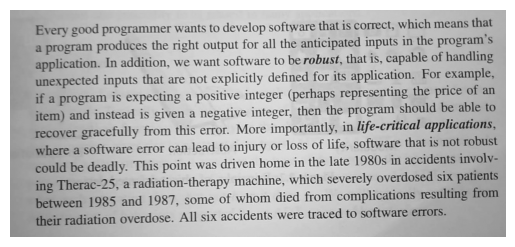

In [6]:
# image import 

# load grayscale image 
img = cv2.imread("assets/text_img.jpeg",1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# display raw image
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.show()

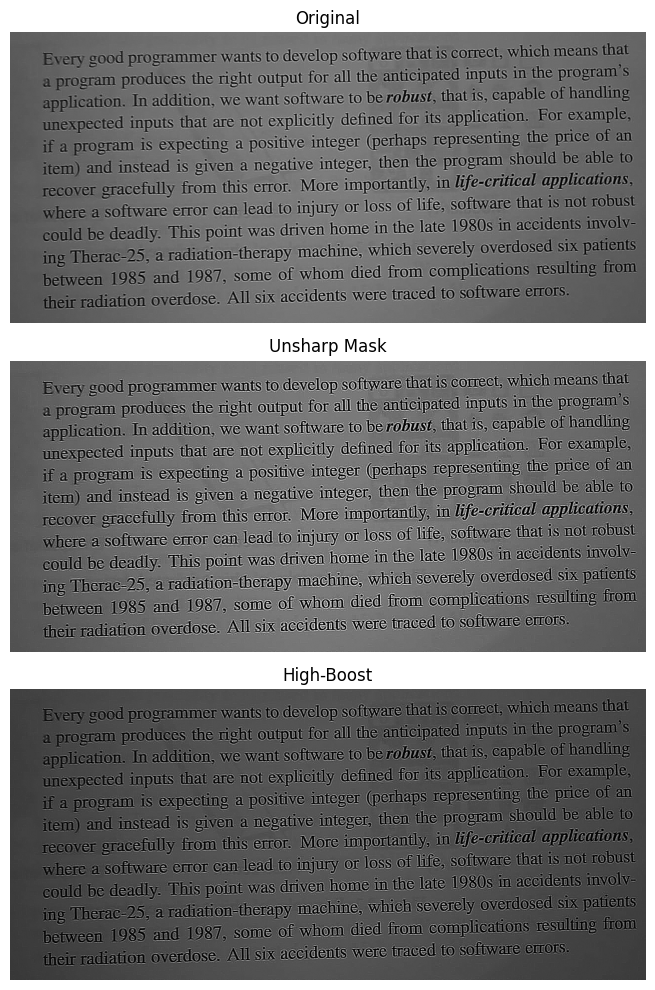

In [10]:
# Image sharpening
from src.filters.builder import FilterBuilder
from src.filters.interface import IFilter
from src.types.filters import FilterType

unsharp_filter = FilterBuilder.Build(FilterType.UNSHARP_MASKING,strength = 1.5)
unsharp_img =  unsharp_filter.Filter(img)

highboost_filter = FilterBuilder.Build(FilterType.HIGH_BOOST,A=1.7)
highboost_img = highboost_filter.Filter(img)

# --- Plot Results ---
titles = ['Original', 'Unsharp Mask', 'High-Boost']
images = [img, unsharp_img, highboost_img]

plt.figure(figsize=(16,10))
for i, (title, img) in enumerate(zip(titles, images)):
    plt.subplot(3, 1, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

- Note that unsharp masking produces the best result

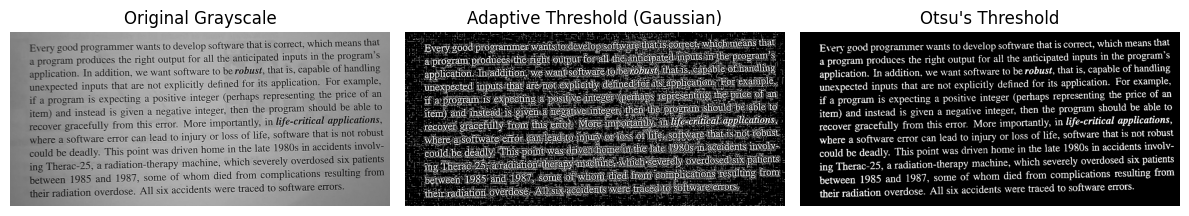

In [6]:
# choose the unsharp masking method
img = unsharp_img

# --- Adaptive Thresholding (Gaussian) ---
adaptive_thresh = cv2.adaptiveThreshold(
    img,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    11,
    2
)

# --- Otsu's Thresholding ---
_, otsu_thresh = cv2.threshold(
    img,
    0,
    255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

# --- Invert images (so text appears dark on white) ---
adaptive_thresh = 255 - adaptive_thresh
otsu_thresh = 255 - otsu_thresh

# --- Display Results ---
plt.figure(figsize=(12,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Grayscale')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(adaptive_thresh, cmap='gray')
plt.title('Adaptive Threshold (Gaussian)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(otsu_thresh, cmap='gray')
plt.title("Otsu's Threshold")
plt.axis('off')

plt.tight_layout()
plt.show()

- Clearly Otsu Thresholding gives the best results

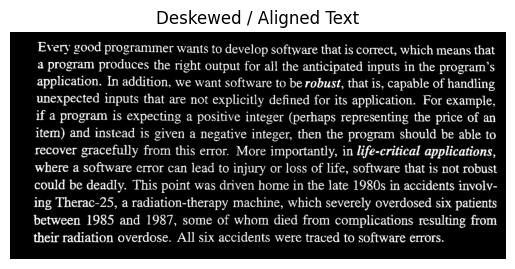

True

In [ ]:
# choosing otsu thresholding
img = otsu_thresh

# Deskewing and aligning text
def align_text(img_thresh):
    # Find all coordinates where pixel value > 0 (white pixels, i.e., text region)
    coords = np.column_stack(np.where(img_thresh > 0))
    
    # Compute the angle of the minimum-area bounding box around those coordinates
    angle = cv2.minAreaRect(coords)[-1]

    # Adjust the angle to get proper rotation direction
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Get image center
    (h, w) = img_thresh.shape
    center = (w // 2, h // 2)

    # Compute rotation matrix for deskewing
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate the image with cubic interpolation, replicating border pixels
    rotated = cv2.warpAffine(
        img_thresh, M, (w, h),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_REPLICATE
    )

    return rotated

def align_text(img_thresh):
    """
    Robustly deskews a binarized image by finding the minimum area bounding box
    around the text and rotating it to be horizontal.
    """
    # 1. FIX: Ensure coordinates are in (x, y) format and float32.
    # np.where returns (row, col) -> (y, x). We need to swap them.
    # cv2.minAreaRect works best with float32 data type.
    coords = np.column_stack(np.where(img_thresh > 0))
    coords = coords[:, ::-1].astype(np.float32) # Swap (y,x) to (x,y) and set type

    # 2. Get the minimum area bounding rectangle
    # It returns: (center(x,y), (width, height), angle of rotation)
    rect = cv2.minAreaRect(coords)
    
    # 3. ROBUST ANGLE CORRECTION:
    # The angle from minAreaRect is in the range [-90, 0).
    # We use the box dimensions to resolve ambiguity.
    angle = rect[-1]
    width, height = rect[1]

    # If the box is "tall" (height > width), it's likely rotated by ~90 degrees
    # The angle needs a 90-degree adjustment.
    if height > width:
        angle -= 90
        
    print(f"Detected angle: {angle:.2f} degrees")

    # Get image center
    (h, w) = img_thresh.shape
    center = (w // 2, h // 2)

    # Compute rotation matrix to deskew (we rotate by the negative of the detected angle)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate the image
    rotated = cv2.warpAffine(
        img_thresh, M, (w, h),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_REPLICATE
    )

    return rotated

# --- Use it ---
aligned = align_text(img)
img = aligned

plt.imshow(aligned, cmap='gray')
plt.title("Deskewed / Aligned Text")
plt.axis('off')
plt.show()

cv2.imwrite("./assets/test_deskewd.jpg", img)


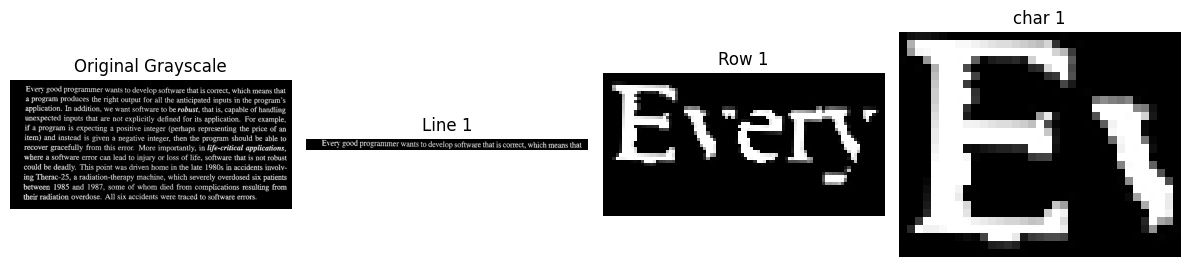

In [ ]:
def segment_lines(image):
    """
    Segments an image into lines of text using Horizontal Projection Profile.
    Args:
        image (np.array): A binarized image (white text on black background).
    Returns:
        list: A list of cropped images, where each image contains one line of text.
    """
    # Create horizontal projection profile
    hpp = np.sum(image, axis=1)
    
    # Find the start and end of each line
    start_indices = []
    end_indices = []
    in_line = False
    for i, val in enumerate(hpp):
        if val > 0 and not in_line:
            start_indices.append(i)
            in_line = True
        elif val == 0 and in_line:
            end_indices.append(i)
            in_line = False
    if in_line: # Handle case where image ends with text
        end_indices.append(len(hpp))
        
    lines = []
    # A small margin can sometimes help
    margin = 2 
    for start, end in zip(start_indices, end_indices):
        # Filter out noise (very short segments)
        if end - start > 5: # min_line_height
            line_crop = image[max(0, start - margin):min(image.shape[0], end + margin), :]
            lines.append(line_crop)
            
    return lines

def segment_words(line_image):
    """
    Segments a line of text into words using Vertical Projection Profile.
    Args:
        line_image (np.array): A binarized, cropped image of a single text line.
    Returns:
        list: A list of cropped images, where each image contains one word.
    """
    # Create vertical projection profile
    vpp = np.sum(line_image, axis=0)
    
    # Heuristic to find the gap threshold between words
    # Gaps between words are typically wider than gaps between characters
    non_zero_counts = vpp[vpp > 0]
    if len(non_zero_counts) == 0: return []
    
    gap_threshold = np.mean(vpp[vpp == 0]) if np.any(vpp == 0) else 10 # Fallback
    # A more robust threshold might be needed for varied fonts/spacing. 
    # For this example, we'll find where the profile is 0.
    
    words = []
    in_word = False
    word_start = 0
    margin = 2
    
    for i, val in enumerate(vpp):
        if val > 0 and not in_word:
            word_start = i
            in_word = True
        elif val == 0 and in_word:
            # Filter out very thin segments (noise or 'i', 'l')
            if i - word_start > 3:
                word_crop = line_image[:, max(0, word_start - margin):min(line_image.shape[1], i + margin)]
                words.append(word_crop)
            in_word = False
            
    if in_word: # Handle case where line ends with a word
        if len(vpp) - word_start > 3:
            word_crop = line_image[:, max(0, word_start - margin):min(line_image.shape[1], len(vpp) + margin)]
            words.append(word_crop)
            
    return words

def segment_characters_connected_components(word_image):
    """
    Segments a word into characters using Connected Components Analysis.
    Args:
        word_image (np.array): A binarized, cropped image of a single word.
    Returns:
        list: A list of cropped images, sorted left-to-right, for each character.
    """
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(word_image, 8, cv2.CV_32S)
    
    characters = []
    components = []
    
    # Start from 1 to skip the background component
    for i in range(1, num_labels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        
        # Filter out tiny noise components based on area or height
        if h > 5:
            component_crop = word_image[y:y+h, x:x+w]
            components.append((x, component_crop))
            
    # Sort components by their x-coordinate to ensure correct character order
    components.sort(key=lambda item: item[0])
    
    characters = [comp[1] for comp in components]
    return characters

sample_image = img

# 2. Segment into Lines
lines = segment_lines(sample_image)
rows = segment_words(lines[0])
chars = segment_characters_connected_components(rows[0])

# --- Display Results ---
plt.figure(figsize=(12,5))
plt.subplot(1, 4, 1)
plt.imshow(sample_image, cmap='gray')
plt.title('Original Grayscale')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(lines[0], cmap='gray')
plt.title('Line 1')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(rows[0], cmap='gray')
plt.title("Row 1")
plt.axis('off')


plt.subplot(1, 4, 4)
plt.imshow(chars[0], cmap='gray')
plt.title("char 1")
plt.axis('off')

plt.tight_layout()
plt.show()
    

In [10]:
# using pytesseract

for i in range(len(rows)):
  print(pytesseract.image_to_string(rows[i],config=custom_config))

Every

good

programmer

wants

to

devel

Op


oftware

that


corre

ct,

which





that

